## UNet starter for Steel defect detection challenge
Credits - https://www.kaggle.com/rishabhiitbhu/unet-starter-kernel-pytorch-lb-0-88/data?select=train.csv

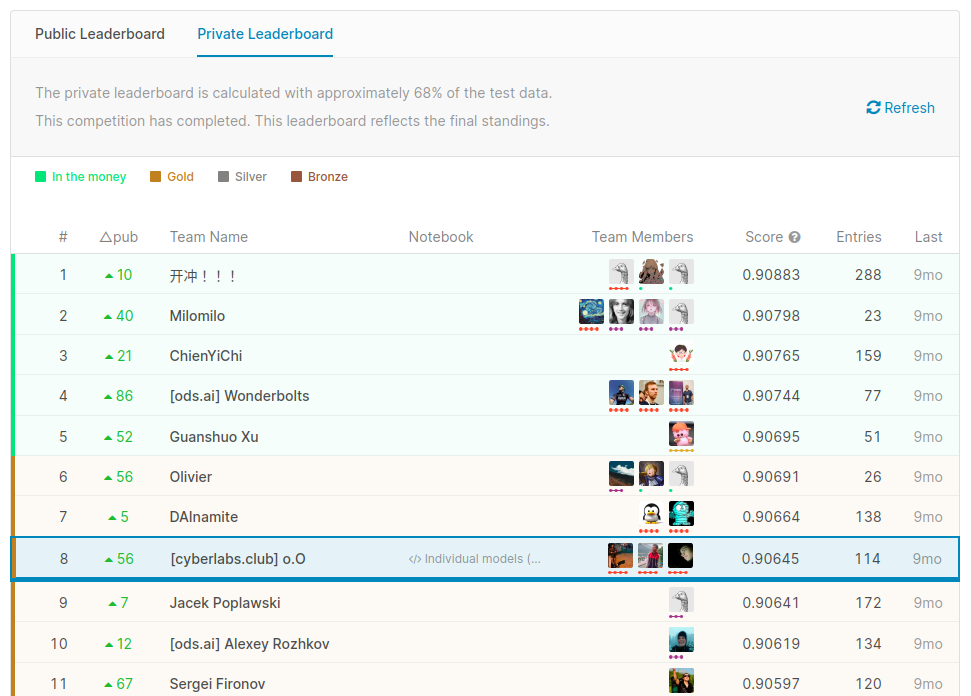

# TEAM

### Rishabh Tiwari - [LINKEDIN](https://www.linkedin.com/in/rishabh-tiwari16/)

### Udbhav Bamba - [LINKEDIN](https://www.linkedin.com/in/ubamba98/)

### Arnav Chavan - [LINKEDIN](https://www.linkedin.com/in/arnav0400/)

# LINKS
Inference Kernel:https://www.kaggle.com/carnav0400/individual-models-normal-pytorch-main-600-6b2ed3?scriptVersionId=22491812

PPT LINK [HOW TO START ML]: https://docs.google.com/presentation/d/1AxVeCddee9suKg5iPrQ0AvfAQFjTsEfGv6mAU04iGvs/edit?usp=sharing

## Imports

In [1]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
import segmentation_models_pytorch as smp
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(47)

## RLE-Mask utility functions

In [3]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

## Dataloader

In [4]:
sample_submission_path = 'sample_submission.csv'
train_df_path = 'train.csv'
data_folder = "."
test_data_folder = "test_images"

In [6]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase,sanity_checking = False):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std,sanity_checking)
        self.fnames = self.df.index.tolist()
        self.sanity_checking = sanity_checking

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if(self.sanity_checking==False):
            mask = mask[0].permute(2, 0, 1)
        return img, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, mean, std, sanity_checking=False):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5),
            ]
        )
    if(sanity_checking==False):
        list_transforms.extend(
            [
                Normalize(mean=mean, std=std, p=1),
                ToTensor(),
            ]
        )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
    sanity_checking = False
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase,sanity_checking)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

In [7]:
temp_dataloader =  provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase='train',
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=1,
                num_workers=4,
                sanity_checking = True
            )

torch.Size([1, 256, 1600, 3])
torch.Size([1, 256, 1600, 4])


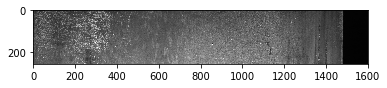

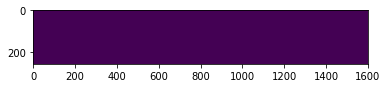

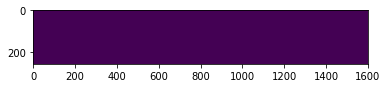

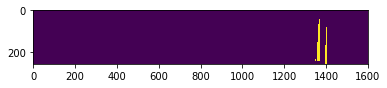

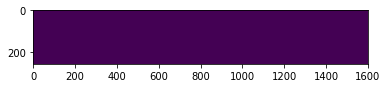

In [9]:
for img, mask in temp_dataloader:
    print(img.shape)
    print(mask.shape)
    plt.imshow(img[0])
    plt.show()
    for i in range(4):
        plt.imshow(mask[0][:,:,i])
        plt.show()
    break

## Some more utility functions

Dice and IoU metric implementations, metric logger for training and validation.

In [10]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


## Model Initialization

In [11]:
model = smp.Unet("resnet18", encoder_weights="imagenet", classes=4, activation=None)

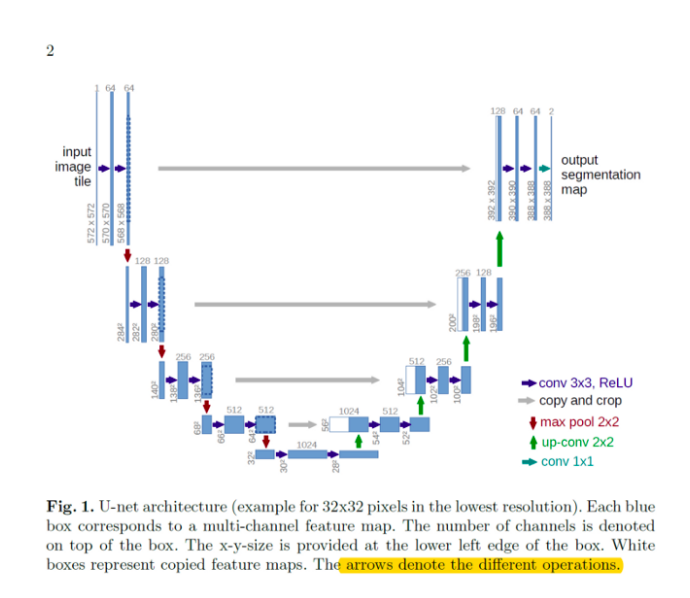

### Training and Validation

In [12]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.num_workers = 4
        self.batch_size = {"train": 2, "val": 2}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 20
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()


In [13]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 06:06:59


KeyboardInterrupt: 

In [ ]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

# Our Approach in short

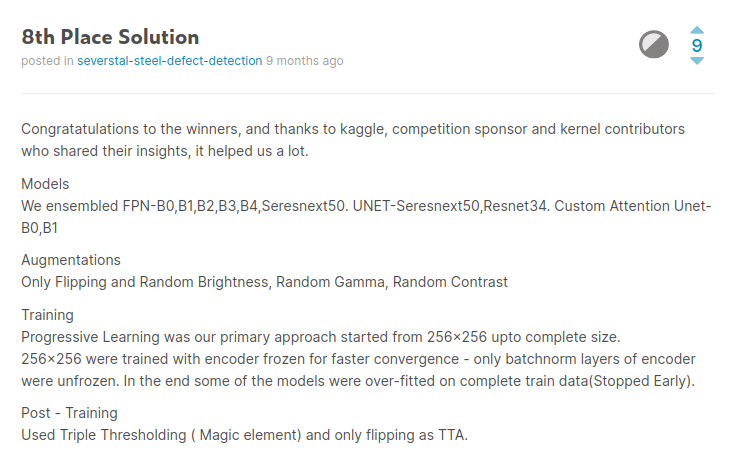

# Triple Thresholding [Post-Processing]
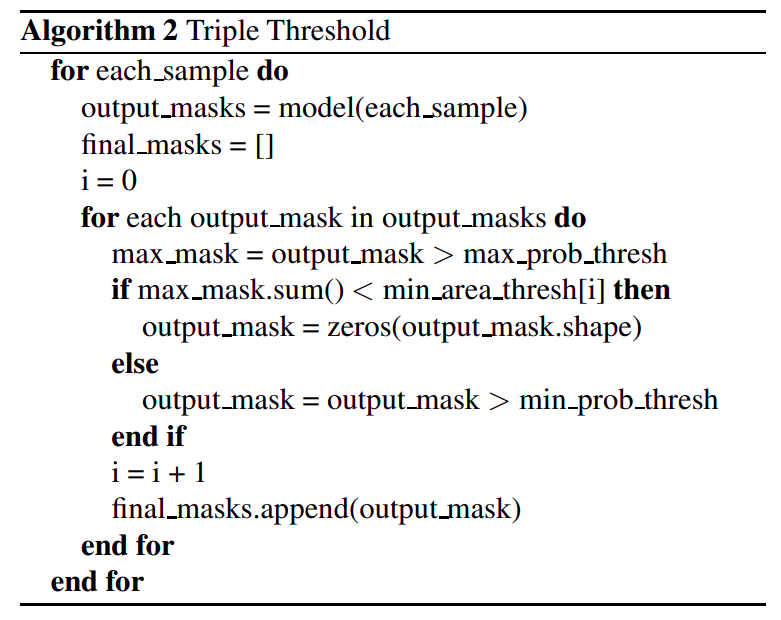